# PUF model and probability distributions

We use the temperature-dependent model for SRAM-PUF as defined by Roel Maes. 
\begin{align*}
r_i^{(j)}=\left\{\begin{matrix}
0 , &\text{if } m_i+d_i\cdot t^{(j)} +w\leq \tau,\\
1 , &\text{if } m_i+d_i \cdot t^{(j)} +w> \tau.
\end{matrix}\right.
\end{align*}
With process variable $m_i \sim \mathcal{N}(\mu_M,\sigma_M^2)$, temperature dependence variable $d_i \sim \mathcal{N}(0,\sigma_D^2)$, noise variable $w_i^{(j)} \sim \mathcal{N}(0,\sigma_N^2)$, and temperature $t^{(j)}$ at time $j$.
Roel also defines some parameters $\lambda_1 = \sigma_N/\sigma_M$, $\lambda_2 = (\tau-\mu_M)/\sigma_M$, and $\theta= \sigma_N / \sigma_D $. 

We refer to the one-probability of cell $i$ as $\xi_i$ and in case of known state-variables, this is given as $\xi_i = \Pr(X=1) = 1- cdf_N(\tau - m_i-d_i \cdot t^{(j)} )=\Phi(\frac{-\tau + m_i + d_i \cdot t^{(j)} }{\sigma_N}) $.

It is our goal to estimate $\lambda_1,\lambda_2,\theta$ for our dataset.

We will use maximum-likelihood estimation to achieve this.

## Settings of parameters

In [3]:
import numpy as np
from scipy.stats import norm 
import matplotlib.pyplot as plt
import srampufparest
# set the parameters
lambda12 = [0.13,0.02]
theta = 45;

# verify srampufparest.loadUnique()
Does it give the same histogram as the code that I used before ?

In [8]:
Nsamples = 60
Ndevices = 96
datapath = r'C:\Users\lkusters\surfdrive\python\server_008104\20181125\Unique'
folder = datapath+'\\002_Temp_025'
_,merged1 = srampufparest.loadUnique(folder)
import os
data25 = [[] for i in range(Nsamples)]
for ii in range(Ndevices):
    count = 0;
    for fname in os.listdir(folder):
        if fname.startswith("Unique_dev%03d"%(ii+1) ):
            data =  np.fromfile(folder+'\\'+fname, np.uint8) 
            data_bits = np.unpackbits(data)
            data25[count].extend(data_bits)
            count += 1;
data25 = np.swapaxes(data25,0,1) # swap axes, s.t. 1st dim is cells, and second is observations

Finished loading data for 96 devices, with 60 observations of 65536 cells
returning observations [96,60,65536] and merged observations [6291456,60]


In [10]:
# from srampufparest
from numpy.random import uniform
print(len(merged1))
N25 = [len(d) for d in merged1] # number of measurements per cell
sums25 = [sum(n) for n in merged1 ]
print(set(N25))
# now generate errorcount
errorcount25 = [sum25 if uniform(0,1,1)>(sum25/Nsamples) else Nsamples-sum25 for sum25 in sums25]

6291456
{60}


In [11]:
# original method
from numpy.random import uniform
print(len(data25))
N25 = [len(d) for d in data25] # number of measurements per cell
sums25 = [sum(n) for n in data25 ]
print(set(N25))
# now generate errorcount
errorcount25 = [sum25 if uniform(0,1,1)>(sum25/Nsamples) else Nsamples-sum25 for sum25 in sums25]

6291456
{60}


# histogram vs pdf


# Pdf of one-probability (no temperature)

We find that apparently the approximations by python (in integrator?) are not accurate enough, since the pdf does not sum to 1 (but instead 0.38). Therefore, we instead use the equations to approximate the cdf and then calculate the pdf by integrating (sum over small intervals). 

## Pdf of the one-probability
\begin{equation}
        p_0(\xi|\lambda_1,\lambda_2)
        = \frac{\lambda_1 \cdot \phi( \Phi^{-1}(\xi) \cdot \lambda_1  +\lambda_2) }{\phi(\Phi^{-1}(\xi))}
\end{equation}

First, we show that indeed the total probability does not sum to 1:

## Cdf of the one-probability


The PDF can be approximated as 
\begin{equation}
        p_0(\xi|\lambda_1,\lambda_2)
        = \Pr(\Xi \leq \xi + \Delta\xi) - \Pr(\Xi \leq \xi - \Delta\xi) ,
\end{equation}
with 
\begin{equation}
        \Pr(\Xi \leq \xi)
        = \Phi( \Phi^{-1}(\xi) \cdot \lambda_1  +\lambda_2) 
\end{equation}

Second show that we can use cdf and integrate to improve the approximation

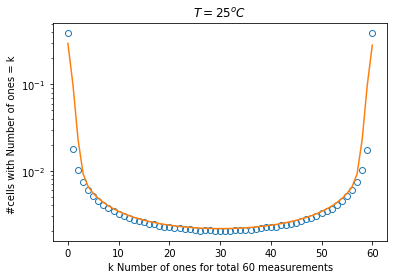

1.0 should be equal to ONE 


In [20]:
# ORIGINAL
# plot the histogram of the number of observed ones in each cell
from scipy.special import comb
pmfdata_sum25,edges = np.histogram(sums25,bins=Nsamples+1,range=(-.5,Nsamples+.5))
plt.plot(range(Nsamples+1),[count/len(data25) for count in pmfdata_sum25] ,'o', fillstyle='none')
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.title('$T=25^oC$')

# Now the fit
l1 = lambda12[0]
l2 = lambda12[1]
NX = 100 # number of steps

xx = [i for i in np.linspace(0,1,NX)]
yy= [norm.cdf(l1*norm.ppf(xi)+l2) for xi in xx]
p0_p = np.diff(yy)
p0_xi = [x+0.5/NX for x in xx[:-1]]
pmf_ones = [0]*(Nsamples+1)
for nones in range(Nsamples+1): # loop over number of ones
    pred = [(xi**nones)*((1-xi)**(Nsamples-nones))*pdfp for (xi,pdfp) in zip(p0_xi,p0_p) ]
    pmf_ones[nones] = comb(Nsamples,nones)*sum(pred)
        
plt.plot(range(Nsamples+1),pmf_ones)
plt.show()
pred = sum(p0_p) # should be 1
print(pred, 'should be equal to ONE ')

Finished generating histogram, with 60 max observations and 6291456 total cells


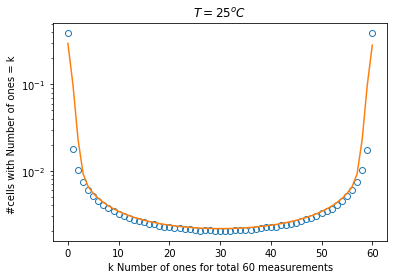

1.0 should be equal to ONE 


In [22]:
# from srampufparest
# plot the histogram of the number of observed ones in each cell
from scipy.special import comb
pmfhist,centers = srampufparest.getcounts1D(merged1)
plt.plot(centers,[count/len(merged1) for count in pmfhist] ,'o', fillstyle='none')
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.title('$T=25^oC$')

# Now the fit
l1 = lambda12[0]
l2 = lambda12[1]
NX = 100 # number of steps

p0_p, p0_xi = srampufparest.pdfp0(l1,l2,NX) 

pmf_ones = [0]*(Nsamples+1)
for nones in range(Nsamples+1): # loop over number of ones
    pred = [(xi**nones)*((1-xi)**(Nsamples-nones))*pdfp for (xi,pdfp) in zip(p0_xi,p0_p) ]
    pmf_ones[nones] = comb(Nsamples,nones)*sum(pred)
        
plt.plot(range(Nsamples+1),pmf_ones)

plt.show()
pred = sum(p0_p) # should be 1
print(pred, 'should be equal to ONE ')

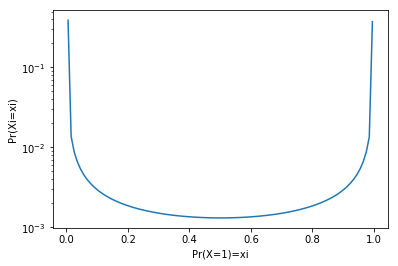

1.0 should be equal to ONE 


In [4]:
# Also plot the pdf
l1 = lambda12[0]
l2 = lambda12[1]
NX = 100 # number of steps

p0_p, p0_xi = srampufparest.pdfp0(l1,l2,NX) 

plt.plot(p0_xi,p0_p)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi)')
plt.show()
pred = sum(p0_p) # should be 1
print(pred, 'should be equal to ONE ')

# Pdf of one-probability (with temperature)


## Pdf of the one-probability
\begin{equation}
        p_1(\xi_2|\xi_1,t_1,t_2,\lambda_1,\lambda_2,\theta)
        = \phi \left(\frac{\theta}{t_2-t_1} \cdot (\Phi^{-1}(\xi_{t_2})-\Phi^{-1}(\xi_{t_1})) \right)   \cdot \frac{\theta}{t_2-t_1}  \cdot  \frac{1 }{\phi(\Phi^{-1}(\xi_{t_2} )  ) }
\end{equation}

First, we show that indeed the total probability does not sum to 1:

## Cdf of the one-probability


The PDF can be approximated as 
\begin{equation}
        p_1(\xi_2|\xi_1,t_1,t_2,\lambda_1,\lambda_2,\theta)
        = \Pr(\Xi_{t_2} \leq \xi_{t_2}+ \Delta\xi|\Xi_{t_1}=\xi_{t_1})  - \Pr(\Xi_{t_2} \leq \xi_{t_2}- \Delta\xi|\Xi_{t_1}=\xi_{t_1}) ,
\end{equation}
with 
\begin{equation}
        \Pr(\Xi_{t_2} \leq \xi_{t_2}|\Xi_{t_1}=\xi_{t_1}) 
        = \Phi \left(\frac{\theta}{t_2-t_1} \cdot (\Phi^{-1}(\xi_{t_2})-\Phi^{-1}(\xi_{t_1})) \right)
\end{equation}

We show that we can use cdf and integrate to improve the approximation

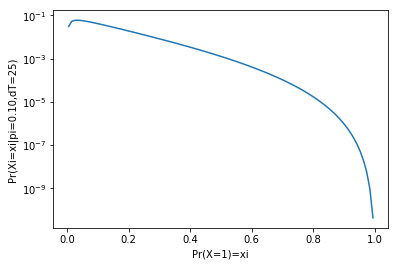

1.0 should be equal to ONE 


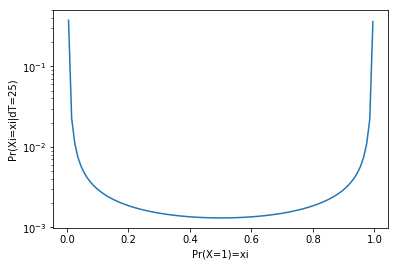

1.0 should be equal to ONE 


In [8]:
# use the CDF
l1 = lambda12[0]
l2 = lambda12[1]
th = theta
NX = 100 # number of steps

dT = 25 # temperature difference

# first we choose single value for pi
pi = 0.1 # xit1
xx = [i for i in np.linspace(0,1,NX)]
yy = [norm.cdf( (th/dT) * (norm.ppf(xi)-norm.ppf(pi)) )   for xi in xx]
p1_p = np.diff(yy)
p1_xi = [x+0.5/NX for x in xx[:-1]]
plt.plot(p1_xi,p1_p)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi|pi=%0.2f,dT=%d)'%(pi,dT))
plt.show()
pred = sum(p1_p)
xx[0]

print(pred, 'should be equal to ONE ')

# second we integrate over all possible pi, to get the average distribution
# we re-use p0_p and p0_xi
ytotal = [ sum( [ Pdfpi*norm.cdf( (th/dT) * (norm.ppf(xi)-norm.ppf(pi)) )  for (Pdfpi,pi) in zip(p0_p,p0_xi) ])   for xi in xx]
ytotal = np.diff(ytotal)
ytotalx = [x+0.5/NX for x in xx[:-1]]

plt.plot(ytotalx,ytotal)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi|dT=%d)'%dT)
plt.show()
pred = sum(ytotal)

print(pred, 'should be equal to ONE ')

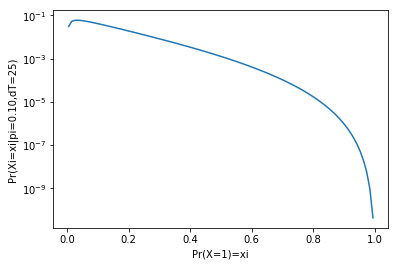

1.0 should be equal to ONE 


In [7]:
# use the CDF
l1 = lambda12[0]
l2 = lambda12[1]
th = theta
NX = 100 # number of steps

dT = 25 # temperature difference

# first we choose single value for pi
pi = 0.1 # xit1
p1_p, p1_xi = srampufparest.pdfp1(pi,dT,l1,l2,th,NX)
plt.plot(p1_xi,p1_p)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi|pi=%0.2f,dT=%d)'%(pi,dT))
plt.show()
pred = sum(p1_p)
xx[0]

print(pred, 'should be equal to ONE ')


In [ ]:
# plot the histogram of the number of observed ones in each cell
pmfdata_sum25,edges = np.histogram(sums25,bins=Nsamples+1,range=(-.5,Nsamples+.5))
plt.plot(range(Nsamples+1),[count/len(data25) for count in pmfdata_sum25] ,'o', fillstyle='none')
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.title('$T=25^oC$')

# now also plot the fit
pmf_est = calculatePmf_kones_noT(lambda12,Nsamples)
plt.plot(range(Nsamples+1),pmf_est)
fig1 = plt.gcf()
plt.show()
fig1.savefig('UNIQUE_kones_pdf.jpg', bbox_inches='tight')

# Build the grid for ML estimation

Now the probability that for any cell we observe $k_1$ ones at temperature $t_1$ and $k_2$ ones at temperature $t_2$, is 
\begin{equation}
    \Pr_{k_1,k_2}(k_1,k_2 |t_1,t_2,\lambda_1,\lambda_2,\theta)
     ={K_1 \choose k_1} {K_2 \choose k_2}  \int_0^1  \xi_1^{k_1} (1-\xi_1)^{K_1 -k_1} p_0(\xi_1|\lambda_1,\lambda_2)   \int_0^1 \xi_2^{k_2} (1-\xi_2)^{K_2 -k_2} p_1(\xi_2|\xi_1,t_1,t_2 ,\lambda_1,\lambda_2,\theta) d \xi_2  d \xi_1 .
\end{equation}

In [9]:
from scipy.special import comb
# preparations
NX = 100
K=60 # number of observations
l1 = 0.1213;
l2 = 0.0210;
th = 45;
dT = 25 # difference between temperatures

xx = [i for i in np.linspace(0,1,NX)]
yy= [norm.cdf(l1*norm.ppf(xi)+l2) for xi in xx]
p0_p = np.diff(yy)
p0_xi = [x+0.5/NX for x in xx[:-1]]

In [ ]:
from scipy.special import comb
import sys
K=60

for th in [45,40,50,35,55]:
    print('Likelihood Pr_{k_1,k_2}(k_1,k_2 |dT,l1,l2,l2), with l1=%0.5f,l2=%0.5f,dT=%d,theta=%d'%(l1, l2, dT, th))

    Pk1k2 = [[0]*(K+1) for k in range(K+1)]
    for k1 in range(K+1):
        comb1 = comb(K,k1)
        for k2 in range(K+1):
            sys.stdout.write("\rCalculating k1=%2.0d,k2=%2.0d" % (k1,k2) )
            total = 0
            for (xi1,pdfxi1) in zip(p0_xi,p0_p):
                yy = [norm.cdf( (th/dT) * (norm.ppf(xi)-norm.ppf(xi1)) )   for xi in xx]
                p1_p = np.diff(yy)
                p1_xi = [x+0.5/NX for x in xx[:-1]]
                int2 = sum([(xi2**k2)*((1-xi2)**(K-k2))*pdfxi2 for (xi2,pdfxi2) in zip(p1_xi,p1_p)])
                total = total+ pdfxi1*int2*(xi1**k1)*((1-xi1)**(K-k1))
            Pk1k2[k1][k2] = comb1*comb(K,k2)*total
    np.savetxt('Pk1k1_(%d).txt.gz' %th , X, delimiter=' ', newline='\n', header='Likelihood Pr_{k_1,k_2}(k_1,k_2 |dT,l1,l2,l2), with l1=%0.5f,l2=%0.5f,dT=%d,theta=%d'%(l1, l2, dT, th), comments='# ')

Likelihood Pr_{k_1,k_2}(k_1,k_2 |dT,l1,l2,l2), with l1=0.12130,l2=0.02100,dT=25,theta=45
Calculating k1= 1,k2=50

In [ ]:
np.savetxt('Pk1k1_(%d).txt.gz' %th , X, delimiter=' ', newline='\n', header='Likelihood Pr_{k_1,k_2}(k_1,k_2 |dT,l1,l2,l2), with l1=%0.5f,l2=%0.5f,dT=%d,theta=%d'%(l1, l2, dT, th), comments='# ')

# Appendix : We can do the same for the pdf of Pe
Again we show that the pdf (approximate by python) does not sum to 1

C:\Users\lkusters\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


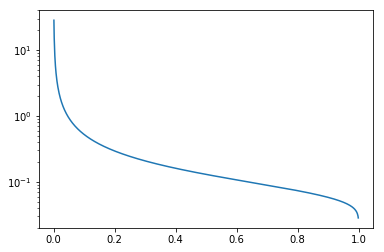

0.3278982407657816


In [4]:
# can we also plot the pdf of Pe ?
lambda12 = [0.13,0.02]
l1 = lambda12[0]
l2 = lambda12[1]
NX = 1000 # number of steps

xx = [i for i in np.linspace(0,1,NX)]
y = [l1*(1-xi)*(norm.pdf(l1*norm.ppf(xi)+l2)+norm.pdf(l1*norm.ppf(xi)-l2))/norm.pdf(norm.ppf(xi)) for xi in xx]
plt.plot(xx,y)
plt.yscale('log')
plt.show()
pred = sum(y[1:-1])/NX
print(pred) # is not even close to 1 !
# this shows us that we are not accurate enough!

Again show that we can use cdf and integrate to improve the approximation

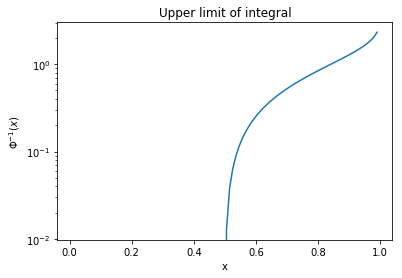

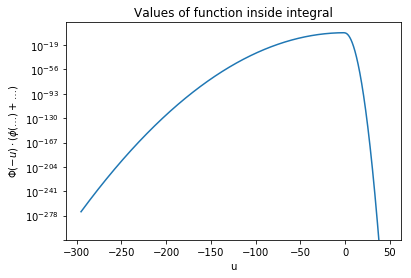

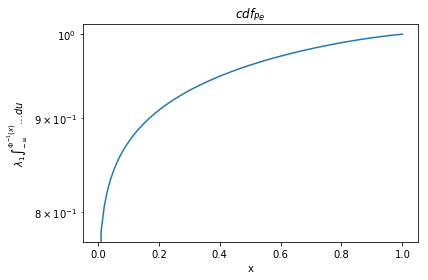

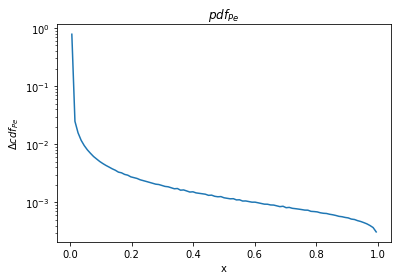

0.9999979999999934


In [5]:
# what if we use cdf instead?
lambda12 = [0.12,0.02]
l1 = lambda12[0]
l2 = lambda12[1]
NX = 100 # number of steps

xx = [i for i in np.linspace(0,1,NX)]
upperlim = [norm.ppf(i) for i in xx] # these are the upper limits of the integral I want to calculate
plt.plot(xx,upperlim)
plt.yscale('log');plt.xlabel('x');plt.ylabel(r'$\Phi^{-1}(x)$')
plt.title('Upper limit of integral')
plt.show()

# Now we generate the part inside the integral
Nu = 500000;
uu = np.linspace(-295,45,Nu) # outside of this range it is 0 anyway
y = [norm.cdf(-u)*(norm.pdf(l1*u+l2)+norm.pdf(l1*u-l2)) for u in uu];
plt.plot(uu,y)
#print(y[90:-355])
plt.yscale('log');
plt.xlabel('u');plt.ylabel(r'$\Phi(-u)\cdot(\phi(\dots)+\dots)$')
plt.title('Values of function inside integral')
plt.show()

# now I wil calculate the values
idxs = [np.searchsorted(uu, upper, side="left") for upper in upperlim];
cdfPe = [(340/Nu)*sum(y[:idx])*l1 for idx in idxs]
plt.plot(xx,cdfPe)
plt.yscale('log');plt.xlabel('x');plt.ylabel(r'$\lambda_1 \int_{-\infty}^{\Phi^{-1}(x)}\dots du$')
plt.title('$cdf_{Pe}$')
plt.show()

# ok! now I have cdf. Can I make pdf ?
pdfPe = np.diff(cdfPe)
plt.plot([x+0.5/NX for x in xx[:-1]],pdfPe)
plt.yscale('log');plt.xlabel('x');plt.ylabel('$\Delta cdf_{Pe}$')
plt.title('$pdf_{Pe}$')
plt.show()

print(sum(pdfPe))